In [1]:
# -*- coding: utf-8 -*-
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append("D:\mnn")
from Mnn_Core.mnn_pytorch import *
from cifar10_train import *
%matplotlib inline

D:\mnn\Mnn_Core\fast_dawson.py:217: RuntimeWarning: divide by zero encountered in true_divide
  y = -np.power((1/xx-1)*a, 1/alpha)


In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [3]:
EPOCHS = 10
BATCH_SIZE = 512

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(
    root='D:\Data_repos\Cifar10',
    train=True,
    download=False,
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True)

testset = torchvision.datasets.CIFAR10(
    root='D:\Data_repos\Cifar10',
    train=False,
    download=False,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
classic = Mnn_Classic()
temp = torch.load("mnn_classic.pt")
classic.load_state_dict(temp.state_dict())
classic = classic.eval()
fc_net = torch.load("mnn_fc.pt")
fc_net = fc_net.eval()

In [5]:
images = trainset.data
labels = trainset.targets
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
sample_img = list()
sample_label = list()
indx = list()
for i in range(100):
    if labels[i] in sample_label:
        continue
    else:
        sample_img.append(images[i])
        sample_label.append(labels[i])
        indx.append(i)
    if len(sample_label) == 10:
        break

[0, 1, 3, 4, 6, 7, 8, 9, 27, 29]


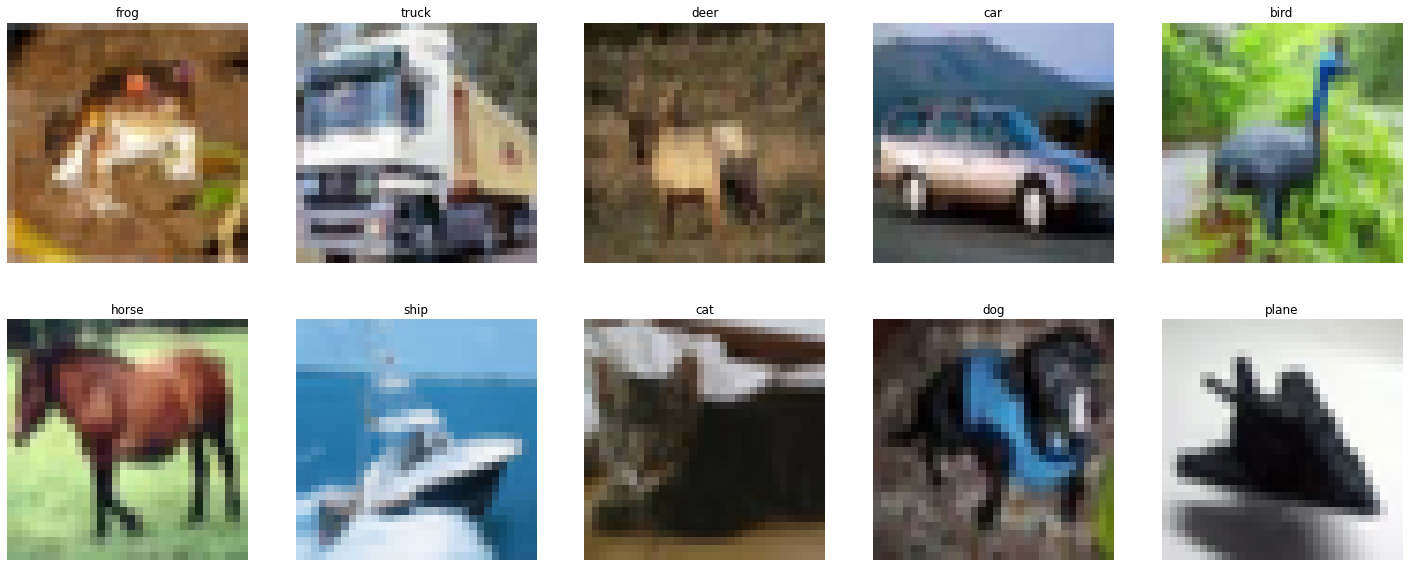

In [7]:
print(indx)
nrow = 2
ncol = 5
fig = plt.figure(figsize=(ncol*5, nrow*5))
for i in range(10):
    ax = fig.add_subplot(nrow, ncol, i+1)
    ax.imshow(sample_img[i])
    ax.set_title(classes[sample_label[i]])
    ax.axis(False)
plt.show()

In [10]:
def denormalise(x):
    y = x.clone().detach()
    y = y.permute(1,2,0)
    y = (y - torch.min(y)) / (torch.max(y) - torch.min(y))
    return y

def fc_predict(image, label, mul_noise=1.0, add_noise=0.0):
    ubar = image.clone().detach()
    ubar = ubar.type(torch.float64)
    ubar = ubar.view(-1, 3*32*32) 
    sbar = torch.sqrt(ubar) * mul_noise + add_noise
    output = fc_net(ubar, sbar)[0]
    _, predicted = torch.max(output.data, 1)
    print("groud true: {:}".format(classes[label]), "## predict:", classes[predicted])

def classic_predict(image, label,  mul_noise=1.0, add_noise=0.0):
    classic.add_noise = add_noise
    classic.mul_noise = mul_noise
    image = image.view(-1, 3, 32, 32)
    image = image.type(torch.float64)
    output = classic(image)[0]
    _, predicted = torch.max(output.data, 1)
    print("groud true: {:}".format(classes[label]), "## predict:", classes[predicted])

In [38]:
image, label = trainset[7]
# x.view(-1, 64 * 4 * 4)
classic_predict(image, label, 
                mul_noise=torch.rand(1, 64*4*4)*10000,
                add_noise=0.0)

groud true: horse ## predict: plane


In [41]:
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 7])
